# Country's bounded-Coordinates to Polygon-Objects
Continuing from the previous Notebook - **Collecting geojson data of countries**, we will observe a country's coordinate-list ("coords" column below) and go about converting them to geometric **Polygon** objects.

In [1]:
import numpy as np
import pandas as pd

# Loading our saved dataframe via Numpy
country_df = np.load('country_df.npy', allow_pickle = True).item()['df']

country_df.tail() # Sneak-peak of our df's tail this time

,country,iso_a3,polytype,coords
250,Samoa,WSM,MultiPolygon,"[[[[-171.5700170559999, -13.938164971999925], ..."
251,Yemen,YEM,MultiPolygon,"[[[[53.308239457000155, 12.11839453700017], [5..."
252,South Africa,ZAF,MultiPolygon,"[[[[37.86378014400023, -46.94085051899984], [3..."
253,Zambia,ZMB,Polygon,"[[[31.11983646700014, -8.616630553999912], [31..."
254,Zimbabwe,ZWE,Polygon,"[[[30.010653524000077, -15.64622731499989], [3..."


The difference between "MultiPolygon" and "Polygon" coordinate-lists, is simply in their names (*Multi* Polygon = *Many* Polygons). 

So every **"Polygon"**-list (within 'coords' column) should have **one layer** of coordinates (list-size of 1), compared to many *n* layers within MultiPolygon-lists. Lets see:

In [2]:
comment = 'Coordinate-lists containing only 1 layer, are of type %s:\n'

copy_df = country_df.copy()
copy_df['layers'] = copy_df.apply(lambda x: len(x['coords']), axis=1)

one_layered_polytypes = 'and'.join(copy_df[copy_df.layers == 1].polytype.unique())

print(comment % one_layered_polytypes)
copy_df[['country','polytype','layers','coords']].head()

Coordinate-lists containing only 1 layer, are of type Polygon:



,country,polytype,layers,coords
0,Aruba,Polygon,1,"[[[-69.99693762899992, 12.577582098000036], [-..."
1,Afghanistan,Polygon,1,"[[[71.04980228700009, 38.40866445000009], [71...."
2,Angola,MultiPolygon,3,"[[[[11.73751945100014, -16.692577982999836], [..."
3,Anguilla,MultiPolygon,2,"[[[[-63.037668423999946, 18.21295807500003], [..."
4,Albania,Polygon,1,"[[[19.747765747000074, 42.57890085900007], [19..."


With the above analysis, we can make a function for converting:
* Polygon-type lists to geometric *Polygon-Objects*.
* MultiPolygon-type lists to *list of Polygon-Objects*. 

---
The **polygonize** function below accomplishes these, where "Polygon-Strings" of a country's coordinate-list are generated and converted to Polygon objects.

More on *wkt.loads( )* used for our String-to-Polygon conversion:  [Shapely's *Well-Known Text* - wkt.loads](https://shapely.readthedocs.io/en/stable/manual.html#shapely.wkt.loads)

In [3]:
from shapely import wkt
from shapely.geometry import MultiPolygon

def polygonize(polygon_coords_list, multi=False, string = False):
    # multi = True -> the coordinate-list type is 'MultiPolygon'

    # To convert a Polygon-type list to a Polygon-Object (or String)
    def single_polygon(coords_list, obj=True):
        if len(coords_list) == 1: # If the list is Unpacked
            coords_list = coords_list[0]
            
        modified_list = list(map(lambda x: str(x)[1:-1].replace(',',''), coords_list))
        polygon_string = 'POLYGON (({}))'.format(','.join(modified_list))
        
        if obj:
            try: # Try-Except to fetch any bad issues:
                polygon_string = wkt.loads(polygon_string)
            except:
                return  # Issues to be analyzed later (TBAL).

        return polygon_string

    # For Polygon-type coordinate-lists (not MultiPolygon):
    if not multi:
        polygon_shape = single_polygon(polygon_coords_list, not string)
        return None if polygon_shape is None else polygon_shape
    
    # Else for a MultiPolygon-list, we make a list of Polygon-Objects (or Strings)
    polygon_obj_list = []
    for sub_list in polygon_coords_list:
        for coords_list in sub_list:
            polygon_obj = single_polygon(coords_list, not string)
            polygon_obj_list.append(polygon_obj)
    
    return MultiPolygon(polygon_obj_list)

### Displaying geometric-shapes of Countries:
Lets apply our function on coordinate-lists of some random 3 countries and view their geometric-shapes.

__________________________
Shape of Jordan: (Polygon)


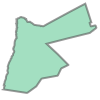


_______________________________
Shape of Greece: (MultiPolygon)


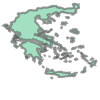


________________________
Shape of Mali: (Polygon)


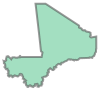

In [4]:
import random 
random_rows = random.sample(range(country_df.shape[0]), 3)

for i in random_rows:
    row = country_df.loc[i]
    if_multiPolygon = (row.polytype == 'MultiPolygon')
    
    geo_shape = polygonize(row.coords, if_multiPolygon)
    
    comment = f"Shape of {row.country}: ({row.polytype})"
    
    print('_'*len(comment) + '\n' + comment)
    display(geo_shape)
    print()

### Adding Polygons, more modifications to our dataframe
Now we add a new column "geo" in our dataframe containing Polygon-Objects for every country, and save this dataframe for later uses. (Also setting country-names as our df's index)

In [5]:
country_df['geo'] = country_df.apply(lambda x: 
                                     polygonize(x['coords'],
                                                multi = x['polytype'] == 'MultiPolygon'
                                                # Or == 'Polygon',it doesn't matter
                                               ), axis=1)
# Setting our new index by country-names
country_df.set_index('country', inplace=True) 

# Dropping 'coords' column, since coordinate-lists are 
# contained as Polygon-form in the 'geo' column:
country_df.drop('coords', axis=1, inplace=True)

# Saving our dataframe
np.save('countries_geo', {'df': country_df}, allow_pickle=True)

country_df.head()

ParseException: Expected number but encountered word: '[33.905867961000126'
ParseException: Expected number but encountered word: '[75.20463911900009'


,iso_a3,polytype,geo
country,,,
Aruba,ABW,Polygon,POLYGON ((-69.99693762899992 12.57758209800004...
Afghanistan,AFG,Polygon,"POLYGON ((71.04980228700009 38.40866445000009,..."
Angola,AGO,MultiPolygon,(POLYGON ((11.73751945100014 -16.6925779829998...
Anguilla,AIA,MultiPolygon,(POLYGON ((-63.03766842399995 18.2129580750000...
Albania,ALB,Polygon,"POLYGON ((19.74776574700007 42.57890085900007,..."


### Viewing a single country's geo-shape:

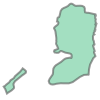

In [6]:
country_df.loc['Palestine'].geo

Geo-shapes for **two countries were not generated** (shown below). Either the *polygonize* function needs refactoring, or our data gave wrong parameters *right from the beginning* (say a coordinate-list identified as "Polygon" in *polytype*, when it should actually be "MultiPolygon"). I coined a term for this stage - **TBAL** (To Be Analyzed Later ... Haha)

In [7]:
print("Following rows TBAL for polygon-shape issues:\n")

country_df[country_df.geo.isna()]

Following rows TBAL for polygon-shape issues:



,iso_a3,polytype,geo
country,,,
Dhekelia Sovereign Base Area,-99,Polygon,None
Kyrgyzstan,KGZ,Polygon,None
